In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from SPHERE.preprocess import *
from SPHERE.SPHERE import *
from SPHERE.utils import *
import numpy as np
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
random_seed = 2022
fix_seed(random_seed)

In [ ]:
adata = sc.read_h5ad('./omni.h5ad')
adata.X[adata.X.nonzero()] = 1
adata.var_names_make_unique()
print(adata)

pca_feat(adata, n_comps=200)
adata.obsm['feat'] = adata.obsm['X_pca'].copy()

AnnData object with n_obs × n_vars = 24621 × 46489
    obs: 'slice_name'
    obsm: 'spatial'


/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:233: RuntimeWarning: divide by zero encountered in divide
  tf = X.multiply(1 / X.sum(axis=1))


In [ ]:
slice_name_list = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11']
adata = construct_neighbor_graph_inte(adata, slice_name_list, loc_neighbors=6, gene_neighbors=20)

In [ ]:
batch_categories = np.unique(adata.obs['slice_name'])
batch_to_index = {batch: idx for idx, batch in enumerate(batch_categories)}
batch_indices = adata.obs['slice_name'].map(batch_to_index).values
num_batches = len(batch_categories)
batch_labels = np.eye(num_batches)[batch_indices]

In [5]:
model = SPHERE(adata, device=device, learning_rate=0.001, epochs=500, dim_hid=64, 
               integrate=True, batch_label=batch_labels,slice_name_list = slice_name_list, lambda_fea_recon=0.8,lambda_spa_recon=1,lambda_recon_pre=4,lambda_con_pre=4.5,
               lambda_recon=4,lambda_con=10,lambda_align=8,lambda_latent=5)

/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:148: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [6]:
output = model.train_inte()
adata.obsm['latent'] = output['latent']
adata.obsm['latent'] = pca(adata, use_reps='latent', n_comps=20)
sc.pp.neighbors(adata, use_rep='latent', n_neighbors=30)
sc.tl.umap(adata)

100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Model training finished!



/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=13, covariance_type='tied', random_state=1234)
y = gm.fit_predict(adata.obsm['latent'], y=None)
adata.obs["leiden"] = pd.Series(y, index=adata.obs.index, dtype='category')

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'slice_name'}, xlabel='UMAP1', ylabel='UMAP2'>

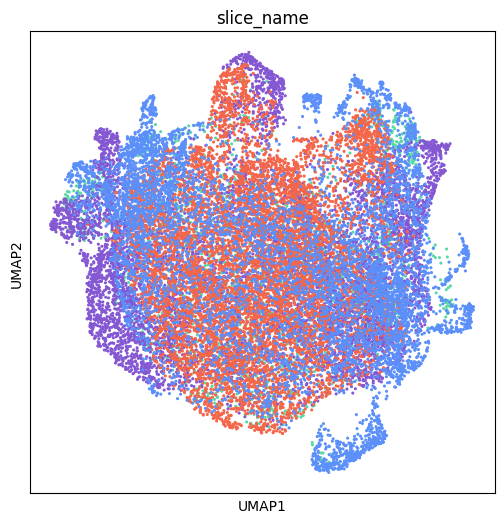

In [17]:
# batch umap
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
plot_color=["#5AD8A6","#8558D3","#8558D3","#8558D3","#F4664A","#F4664A","#F4664A"
            ,"#5B8FF9","#5B8FF9","#5B8FF9","#5B8FF9",]
fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["slice_name"],
    s=20,
    show=False,
    palette=plot_color,
    legend_loc=None,
    ax=ax
)

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'slice_name'}, xlabel='UMAP1', ylabel='UMAP2'>

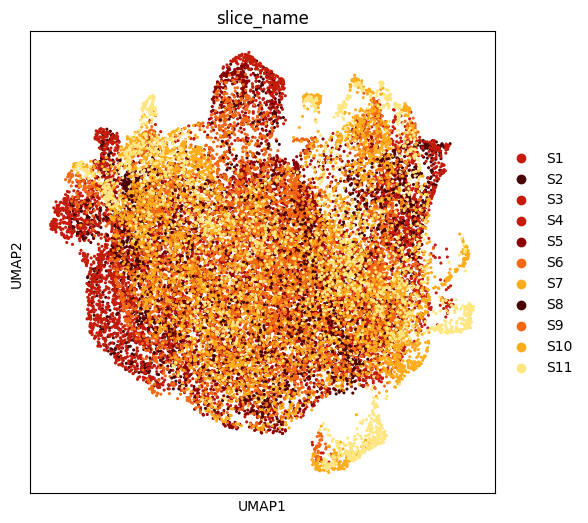

In [18]:
# spatiotemporal umap
plt.rcParams["figure.figsize"] = (6, 6)
plot_color=["#C51B0A","#4A0000","#C51B0A","#C51B0A","#8B0000","#F16913","#FDAD1B"
            ,"#4A0000","#F16913","#FDAD1B","#FFE680",]
fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["slice_name"],
    s=20,
    show=False,
    palette=plot_color,
    ax=ax
)

In [20]:
plot_color = [
    "#00CFC1", "#E38AFF", "#FF4B5C","#FFB38A","#A2D729","#7AE582","#00A8E8","#FF8FA3","#2ECC71","#9B5DE5","#FFD447","#F72585","#FF9F1C"
]
all_clusters = sorted(adata.obs['leiden'].astype(str).unique())
adata.obs['leiden'] = adata.obs['leiden'].astype(str).astype('category')
adata.obs['leiden'] = adata.obs['leiden'].cat.set_categories(all_clusters, ordered=True)
palette_list = [plot_color[i % len(plot_color)] for i in range(len(all_clusters))]
adata.uns['leiden_colors'] = palette_list

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

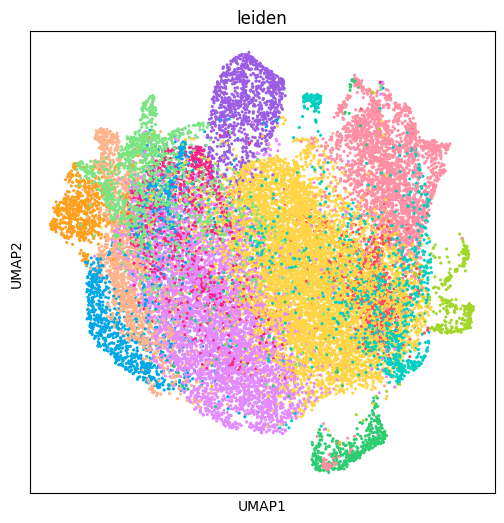

In [21]:
plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["leiden"],
    s=20,
    show=False,
    legend_loc=None,
    ax=ax,palette=palette_list
)

## Liver

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No d

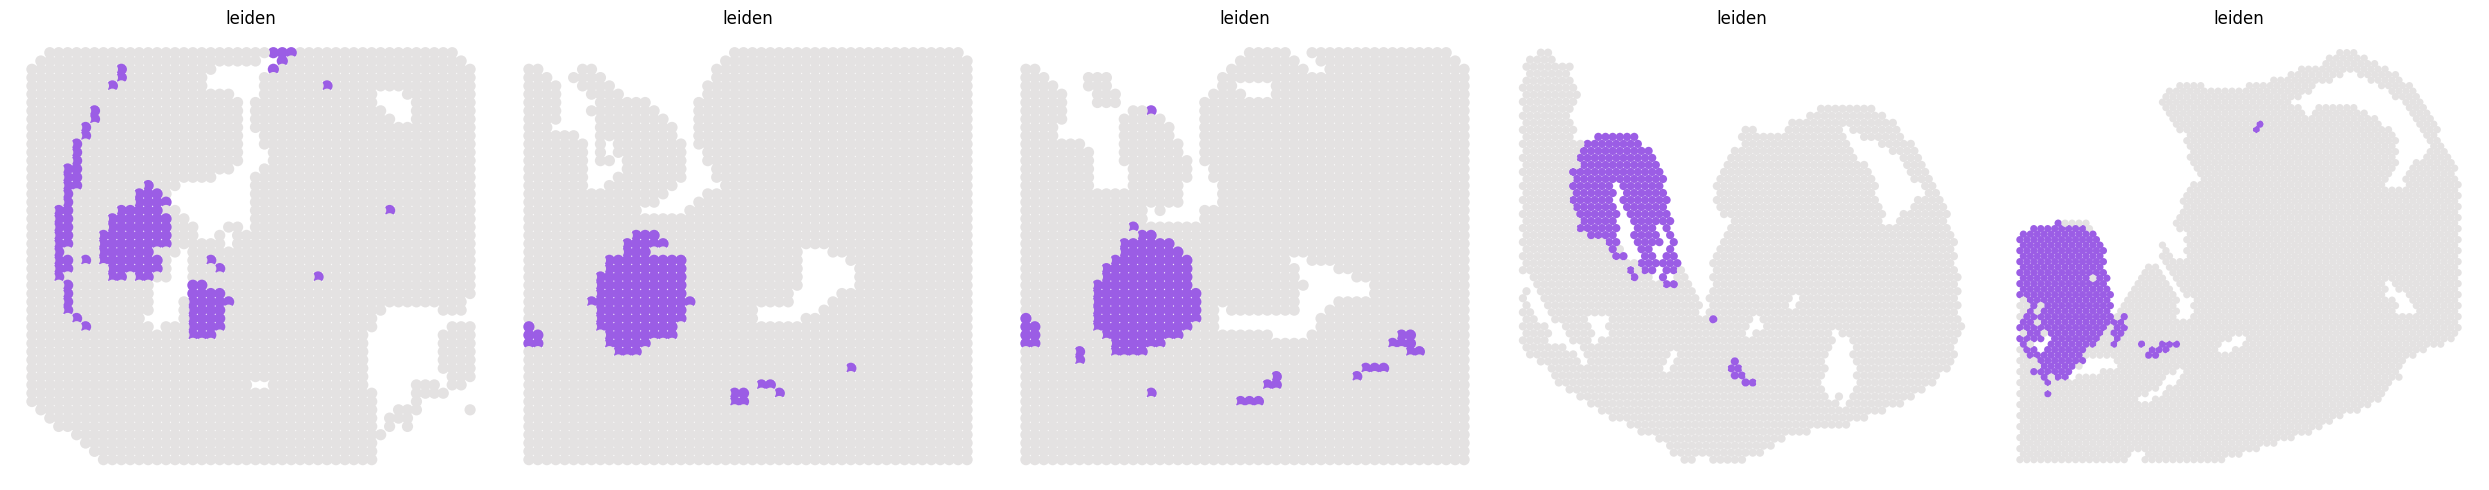

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

adata.obs["leiden"] = adata.obs["leiden"].astype(str).astype("category")
target_cluster = "6"
grey_color = "#E4E2E2"
all_clusters = list(adata.obs["leiden"].cat.categories)

palette_highlight = {cl: grey_color for cl in all_clusters}
idx = all_clusters.index(target_cluster)
palette_highlight[target_cluster] = plot_color[idx]

sizes = [260, 260, 260, 140, 110]
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(1,6):
    adata_sub = adata[adata.obs["slice_name"] == slice_name_list[i]].copy()
    
    sc.pl.embedding(
        adata_sub,
        basis="spatial",
        color="leiden",
        s=sizes[i-1],          
        show=False,
        legend_loc=None,
        frameon=False,
        palette=palette_highlight,
        ax=axes[i-1]
    )

plt.tight_layout()
plt.show()

## Spine

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


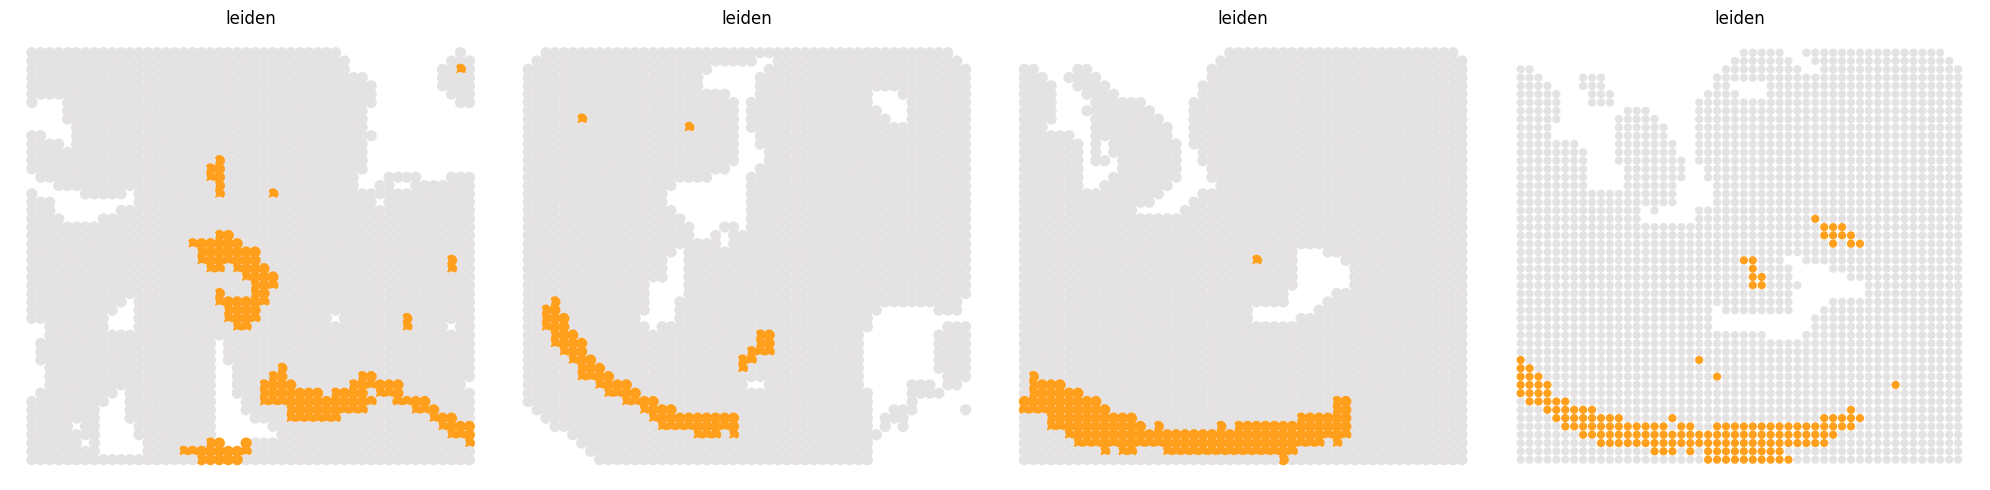

In [32]:
import matplotlib.pyplot as plt
import scanpy as sc

adata.obs["leiden"] = adata.obs["leiden"].astype(str).astype("category")
target_cluster = "9"
grey_color = "#E4E2E2"
all_clusters = list(adata.obs["leiden"].cat.categories)

palette_highlight = {cl: grey_color for cl in all_clusters}
idx = all_clusters.index(target_cluster)
palette_highlight[target_cluster] = plot_color[idx]

# 2) 定义每个 slice 特定的点大小 (对应你代码里的 260, 260, 260, 140, 110)
sizes = [260, 260, 260, 140, 110]

# 3) 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4) 循环绘图
for i in range(4):
    adata_sub = adata[adata.obs["slice_name"] == slice_name_list[i]].copy()
    
    sc.pl.embedding(
        adata_sub,
        basis="spatial",
        color="leiden",
        s=sizes[i],          
        show=False,
        legend_loc=None,
        frameon=False,
        palette=palette_highlight,
        ax=axes[i]
    )

plt.tight_layout()
plt.show()

## Limb

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


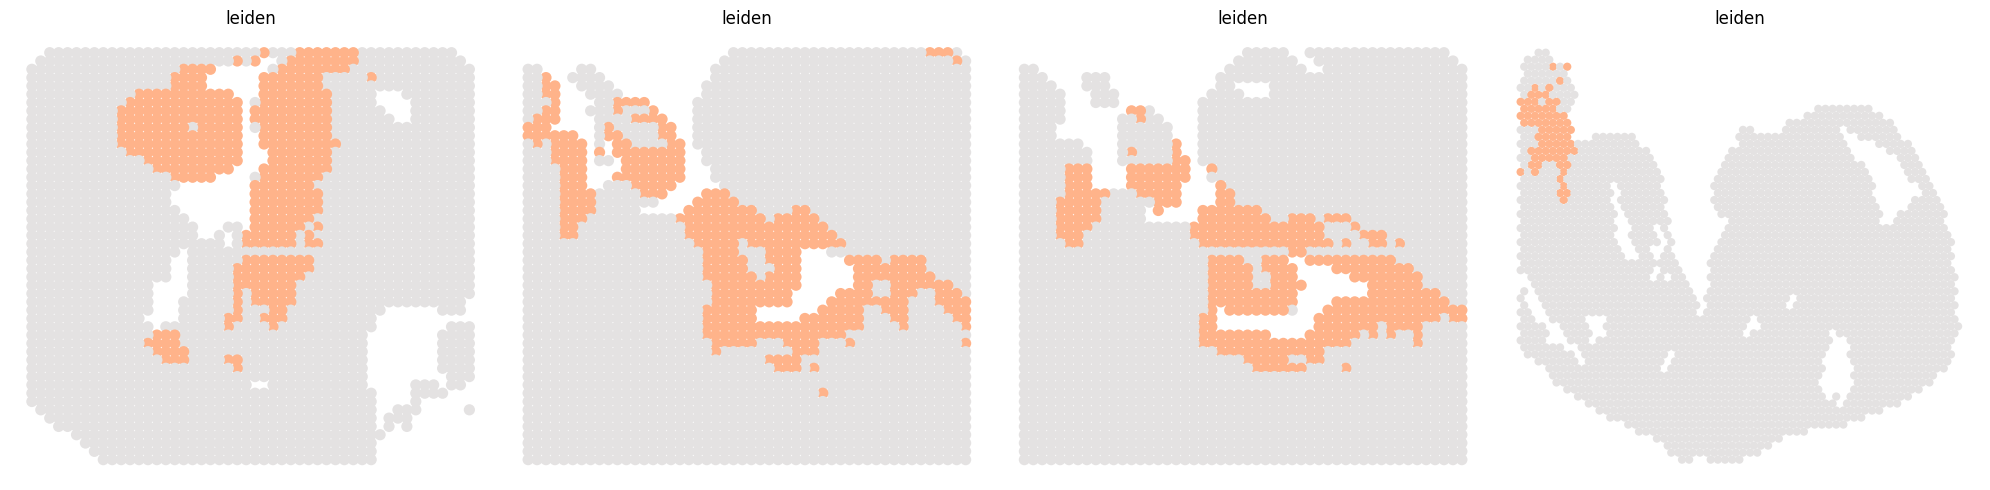

In [33]:
import matplotlib.pyplot as plt
import scanpy as sc

adata.obs["leiden"] = adata.obs["leiden"].astype(str).astype("category")
target_cluster = "11"
grey_color = "#E4E2E2"
all_clusters = list(adata.obs["leiden"].cat.categories)

palette_highlight = {cl: grey_color for cl in all_clusters}
idx = all_clusters.index(target_cluster)
palette_highlight[target_cluster] = plot_color[idx]

# 2) 定义每个 slice 特定的点大小 (对应你代码里的 260, 260, 260, 140, 110)
sizes = [260, 260, 260, 140]

# 3) 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4) 循环绘图
for i in range(1,5):
    adata_sub = adata[adata.obs["slice_name"] == slice_name_list[i]].copy()
    
    sc.pl.embedding(
        adata_sub,
        basis="spatial",
        color="leiden",
        s=sizes[i-1],          
        show=False,
        legend_loc=None,
        frameon=False,
        palette=palette_highlight,
        ax=axes[i-1]
    )

plt.tight_layout()
plt.show()

## Telencephalon

In [34]:
target_clusters = ["4", "5", "12"]  
grey_color = "#E4E2E2"

adata.obs['leiden'] = adata.obs['leiden'].astype('category')
all_clusters = list(adata.obs['leiden'].cat.categories)

palette_highlight = {cl: grey_color for cl in all_clusters}

for cl in target_clusters:
    if cl in all_clusters:
        idx = all_clusters.index(cl)
        palette_highlight[cl] = plot_color[idx]
adata.uns['leiden_colors'] = [palette_highlight[cl] for cl in all_clusters]


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 400x400 with 0 Axes>

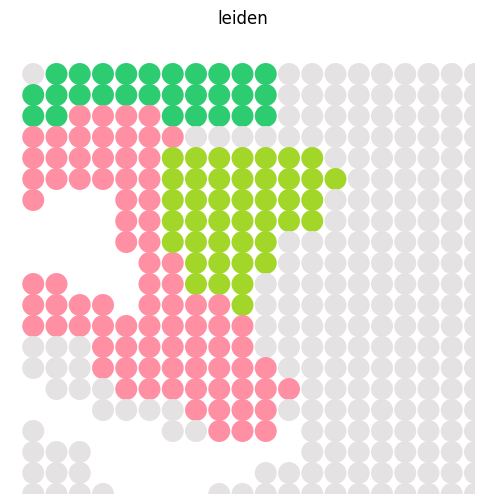

In [46]:
adata_sub = adata[adata.obs['slice_name'] == slice_name_list[0]].copy()
adata_sub.obs['leiden'] = adata_sub.obs['leiden'].astype('category')

cats_sub = list(adata_sub.obs['leiden'].cat.categories)
palette_sub = [palette_highlight[cl] for cl in cats_sub]

plt.figure(figsize=(4, 4))
ax = sc.pl.embedding(
    adata_sub,
    basis="spatial",
    color="leiden",
    s=1000,
    show=False,
    legend_loc=None,
    frameon=False,
    palette=palette_sub,   # 按 cats_sub 对应的颜色
)
ax.set_xlim(-50,-30)
ax.set_ylim(-20,2)
plt.show()

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 400x400 with 0 Axes>

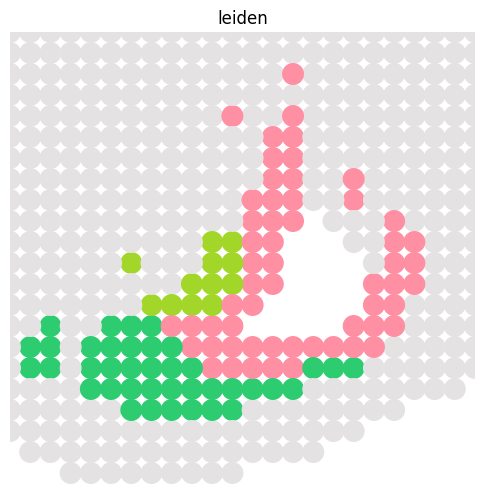

In [58]:
adata_sub = adata[adata.obs['slice_name'] == slice_name_list[8]].copy()
adata_sub.obs['leiden'] = adata_sub.obs['leiden'].astype('category')

cats_sub = list(adata_sub.obs['leiden'].cat.categories)
palette_sub = [palette_highlight[cl] for cl in cats_sub]

plt.figure(figsize=(4, 4))
ax = sc.pl.embedding(
    adata_sub,
    basis="spatial",
    color="leiden",
    s=1000,
    show=False,
    legend_loc=None,
    frameon=False,
    palette=palette_sub,   # 按 cats_sub 对应的颜色
)
ax.set_xlim(15,38)
ax.set_ylim(3,25)
plt.show()

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 400x400 with 0 Axes>

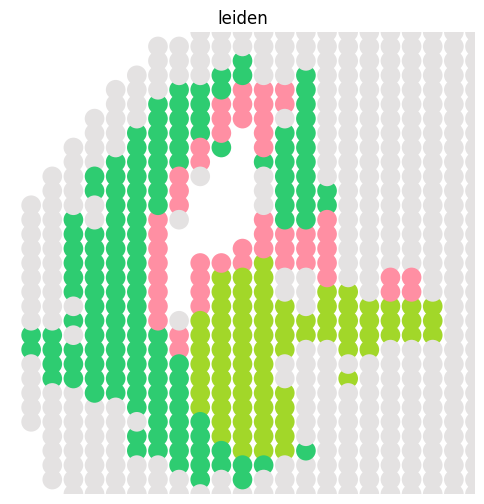

In [71]:
adata_sub = adata[adata.obs['slice_name'] == slice_name_list[9]].copy()
adata_sub.obs['leiden'] = adata_sub.obs['leiden'].astype('category')

cats_sub = list(adata_sub.obs['leiden'].cat.categories)
palette_sub = [palette_highlight[cl] for cl in cats_sub]

plt.figure(figsize=(4, 4))
ax = sc.pl.embedding(
    adata_sub,
    basis="spatial",
    color="leiden",
    s=800,
    show=False,
    legend_loc=None,
    frameon=False,
    palette=palette_sub,   # 按 cats_sub 对应的颜色
)
ax.set_xlim(0,22)
ax.set_ylim(6,38)
plt.show()

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 400x400 with 0 Axes>

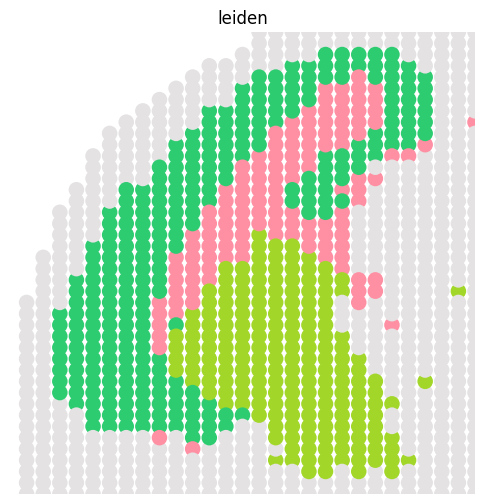

In [82]:
adata_sub = adata[adata.obs['slice_name'] == slice_name_list[10]].copy()
adata_sub.obs['leiden'] = adata_sub.obs['leiden'].astype('category')

cats_sub = list(adata_sub.obs['leiden'].cat.categories)
palette_sub = [palette_highlight[cl] for cl in cats_sub]

plt.figure(figsize=(4, 4))
ax = sc.pl.embedding(
    adata_sub,
    basis="spatial",
    color="leiden",
    s=500,
    show=False,
    legend_loc=None,
    frameon=False,
    palette=palette_sub,   # 按 cats_sub 对应的颜色
)
ax.set_xlim(0,28)
ax.set_ylim(6,47)
plt.show()